In [2]:
import yfinance as yf
import pandas as pd

tickers = ["AAPL","MSFT","AMZN","GOOGL","KO","JNJ","XOM","JPM","TSLA","DIS"]
start_date = "2018-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False,
    group_by="column"
)

# Prendiamo Adj Close (se manca, fallback su Close)
if isinstance(raw.columns, pd.MultiIndex) and ("Adj Close" in raw.columns.get_level_values(0)):
    prices = raw["Adj Close"].copy()
else:
    prices = raw["Close"].copy()

# Pulizia: ordina date, rimuovi righe con NA (giorni non comuni a tutti i ticker)
prices = prices.sort_index().dropna(how="any")

print("Period:", prices.index.min().date(), "->", prices.index.max().date())
print("Observations:", prices.shape[0], "| Assets:", prices.shape[1])
prices.head()

Period: 2018-01-02 -> 2026-02-04
Observations: 2034 | Assets: 10


Ticker,AAPL,AMZN,DIS,GOOGL,JNJ,JPM,KO,MSFT,TSLA,XOM
Date,,,,,,,,,,
2018-01-02,40.341885,59.450500,106.224541,53.258095,111.353020,86.340874,35.492729,79.050377,21.368668,58.970890
2018-01-03,40.334866,60.209999,106.680588,54.166729,112.416687,86.428864,35.414795,79.418274,21.150000,60.129086
2018-01-04,40.522217,60.479500,106.633087,54.377136,112.408737,87.667015,35.913593,80.117279,20.974667,60.212303
2018-01-05,40.983578,61.457001,106.053497,55.098190,113.336464,87.104240,35.905807,81.110558,21.105333,60.163773
2018-01-08,40.831352,62.343498,104.533295,55.292721,113.480431,87.232864,35.851246,81.193352,22.427334,60.434242


In [3]:
# Controllo missing per ticker prima del dropna (informativo)
missing_by_ticker = raw["Adj Close"].isna().sum() if isinstance(raw.columns, pd.MultiIndex) else raw.isna().sum()
missing_by_ticker = missing_by_ticker.sort_values(ascending=False)
missing_by_ticker.head(10)

,0
Ticker,
AAPL,0
AMZN,0
DIS,0
GOOGL,0
JNJ,0
JPM,0
KO,0
MSFT,0
TSLA,0


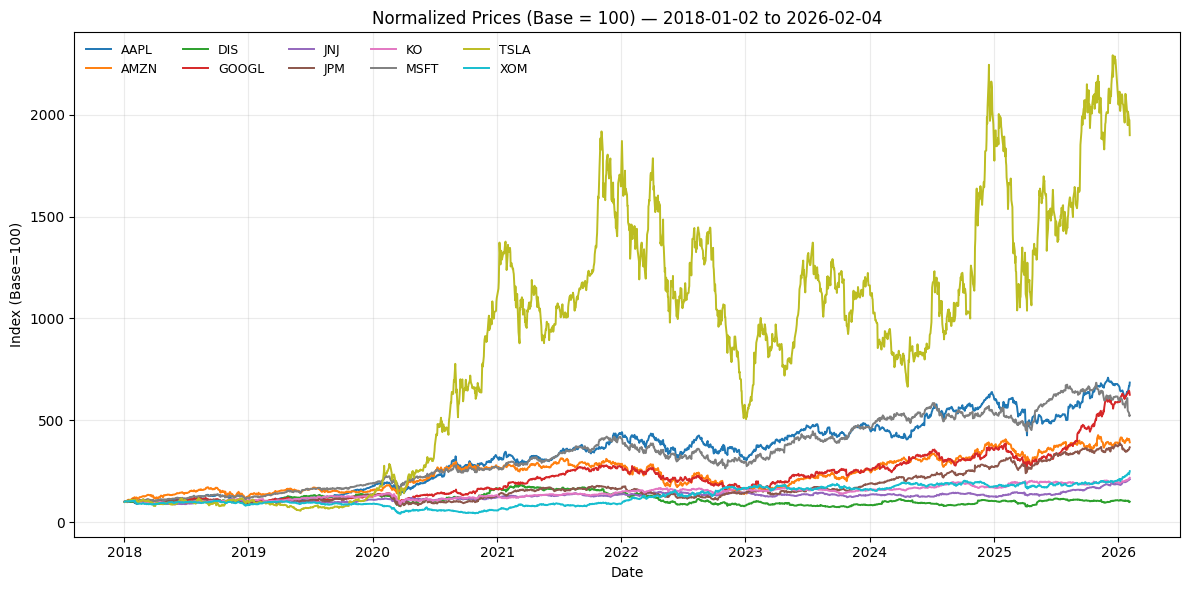

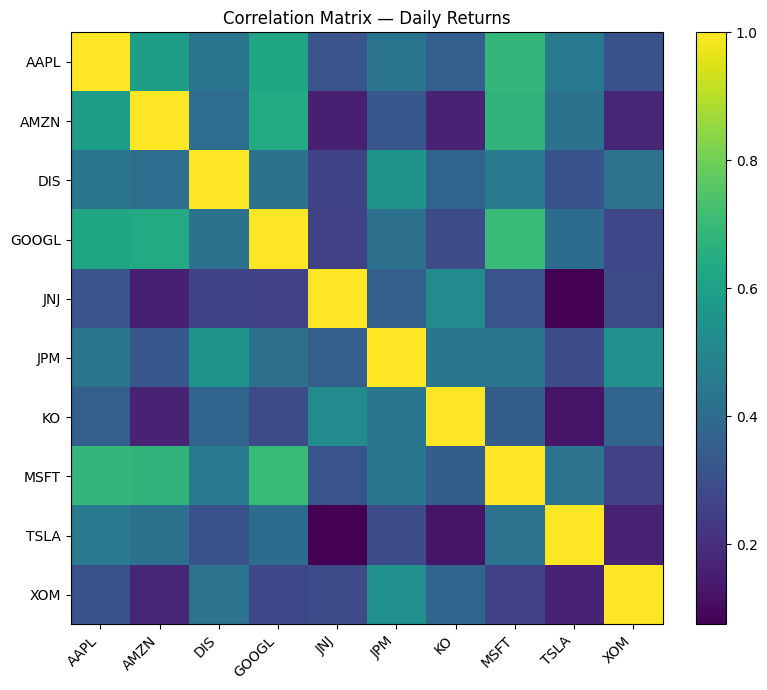

,Start Price,End Price,Total Return %
Ticker,,,
TSLA,21.368668,406.010010,1800.024921
AAPL,40.341885,276.489990,585.367064
GOOGL,53.258095,333.040009,525.332186
MSFT,79.050377,414.190002,423.957024
AMZN,59.450500,232.990005,291.905877
JPM,86.340874,317.269989,267.462101
XOM,58.970890,147.589996,150.276020
KO,35.492729,77.349998,117.931955
JNJ,111.353020,234.470001,110.564565


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# STEP 2 — Visual EDA
# =========================

# 2.1 Prices normalizzati (base=100)
base = 100
prices_norm = prices / prices.iloc[0] * base

plt.figure(figsize=(12, 6))
for c in prices_norm.columns:
    plt.plot(prices_norm.index, prices_norm[c], linewidth=1.4, label=c)
plt.title("Normalized Prices (Base = 100) — 2018-01-02 to 2026-02-04")
plt.xlabel("Date")
plt.ylabel("Index (Base=100)")
plt.legend(ncol=5, fontsize=9, frameon=False)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# 2.2 Daily returns + Correlation heatmap (matplotlib only)
rets = prices.pct_change().dropna()
corr = rets.corr()

plt.figure(figsize=(9, 7))
im = plt.imshow(corr.values, interpolation="nearest")
plt.title("Correlation Matrix — Daily Returns")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# (opzionale ma utile) quick summary
summary = pd.DataFrame({
    "Start Price": prices.iloc[0],
    "End Price": prices.iloc[-1],
    "Total Return %": (prices.iloc[-1] / prices.iloc[0] - 1) * 100
}).sort_values("Total Return %", ascending=False)

summary

In [5]:
import numpy as np
import pandas as pd

TRADING_DAYS = 252

# Daily returns
rets = prices.pct_change().dropna()

# Annualized expected returns (simple arithmetic mean)
mu_annual = rets.mean() * TRADING_DAYS

# Annualized covariance matrix
cov_annual = rets.cov() * TRADING_DAYS

# Annualized volatility
vol_annual = rets.std() * np.sqrt(TRADING_DAYS)

# Summary table (clean, report-ready)
summary_stats = pd.DataFrame({
    "Exp Return (ann.)": mu_annual,
    "Volatility (ann.)": vol_annual
}).sort_values("Exp Return (ann.)", ascending=False)

summary_stats

,Exp Return (ann.),Volatility (ann.)
Ticker,,
TSLA,0.565399,0.634497
AAPL,0.285812,0.307271
GOOGL,0.274984,0.308771
MSFT,0.246089,0.285322
AMZN,0.228272,0.343464
JPM,0.203329,0.290055
XOM,0.159271,0.301695
KO,0.115302,0.193029
JNJ,0.111472,0.195534


In [6]:
summary_stats["Return/Vol"] = summary_stats["Exp Return (ann.)"] / summary_stats["Volatility (ann.)"]
summary_stats.sort_values("Return/Vol", ascending=False)

,Exp Return (ann.),Volatility (ann.),Return/Vol
Ticker,,,
AAPL,0.285812,0.307271,0.930161
TSLA,0.565399,0.634497,0.891099
GOOGL,0.274984,0.308771,0.890577
MSFT,0.246089,0.285322,0.862497
JPM,0.203329,0.290055,0.701003
AMZN,0.228272,0.343464,0.664615
KO,0.115302,0.193029,0.597329
JNJ,0.111472,0.195534,0.570091
XOM,0.159271,0.301695,0.527921


In [7]:
# quick inspection of extreme values
print("Max exp return:", summary_stats["Exp Return (ann.)"].max())
print("Max volatility:", summary_stats["Volatility (ann.)"].max())

Max exp return: 0.5653989737261659
Max volatility: 0.6344965392592469


In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

tickers = mu_annual.index.tolist()
n = len(tickers)

mu = mu_annual.values
Sigma = cov_annual.values

def port_return(w):
    return float(w @ mu)

def port_vol(w):
    return float(np.sqrt(w @ Sigma @ w))

def port_var(w):
    return float(w @ Sigma @ w)

# Constraints: sum(w)=1
cons_sum = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

# Bounds: long-only + cap (metti cap=None se non vuoi)
cap = 0.30
bounds = tuple((0.0, cap) for _ in range(n))

w0 = np.repeat(1/n, n)

In [9]:
# SCENARIO 1 - MINIMIZZA RISCHIO DATO UN RENDIMENTO TARGET
def min_vol_for_target(target_ret):
    cons = (
        cons_sum,
        {"type": "eq", "fun": lambda w: port_return(w) - target_ret},
    )
    res = minimize(port_var, w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res

# range target (evita estremi troppo aggressivi)
r_min, r_max = mu_annual.min(), mu_annual.max()
targets = np.linspace(r_min, r_max, 40)

frontier = []
weights_list = []

for tr in targets:
    res = min_vol_for_target(tr)
    if res.success:
        w = res.x
        frontier.append((port_vol(w), port_return(w)))
        weights_list.append(w)

frontier_df = pd.DataFrame(frontier, columns=["vol", "ret"])
frontier_df.head()

,vol,ret
0,0.175052,0.101375
1,0.168209,0.114632
2,0.164478,0.127890
3,0.163013,0.141148
4,0.163394,0.154406


In [12]:
#SCENARIO 2 - MASSIMIZZA IL RENDIMENTO DATO UN LIVELLO DI RISCHIO TARGET
def max_ret_with_var_cap(target_vol):
    target_var = target_vol**2
    cons = (
        cons_sum,
        {"type": "ineq", "fun": lambda w: target_var - port_var(w)}  # >=0 -> var(w) <= target_var
    )
    res = minimize(lambda w: -port_return(w), w0, method="SLSQP", bounds=bounds, constraints=cons)
    return res

v_min, v_max = frontier_df["vol"].min(), frontier_df["vol"].max()
vol_targets = np.linspace(v_min, v_max, 30)

frontier2, weights_list2 = [], []
for tv in vol_targets:
    res = max_ret_with_var_cap(tv)
    if res.success:
        w = res.x
        frontier2.append((port_vol(w), port_return(w)))
        weights_list2.append(w)

frontier2_df = pd.DataFrame(frontier2, columns=["vol", "ret"])
frontier2_df.head(), len(frontier2_df)

(        vol       ret
 0  0.163013  0.147949
 1  0.168246  0.177862
 2  0.173480  0.190342
 3  0.178713  0.200547
 4  0.183947  0.209608,
 30)

In [11]:
# Prendi il portafoglio con miglior return/vol dalla frontiera (proxy Sharpe senza rf)
idx_best = (frontier_df["ret"] / frontier_df["vol"]).idxmax()
w_best = weights_list[idx_best]

best_port = pd.Series(w_best, index=tickers).sort_values(ascending=False)
best_port

,0
JNJ,1.989408e-01
GOOGL,1.946662e-01
TSLA,1.681300e-01
AAPL,1.680566e-01
KO,1.335920e-01
XOM,5.979748e-02
JPM,5.056145e-02
MSFT,2.625551e-02
DIS,5.870955e-17
AMZN,0.000000e+00


In [13]:
print("Best (ret/vol) vol:", port_vol(w_best))
print("Best (ret/vol) ret:", port_return(w_best))
print("Best (ret/vol) ratio:", port_return(w_best)/port_vol(w_best))

Best (ret/vol) vol: 0.22200417123890032
Best (ret/vol) ret: 0.2604686917591764
Best (ret/vol) ratio: 1.1732603504953254


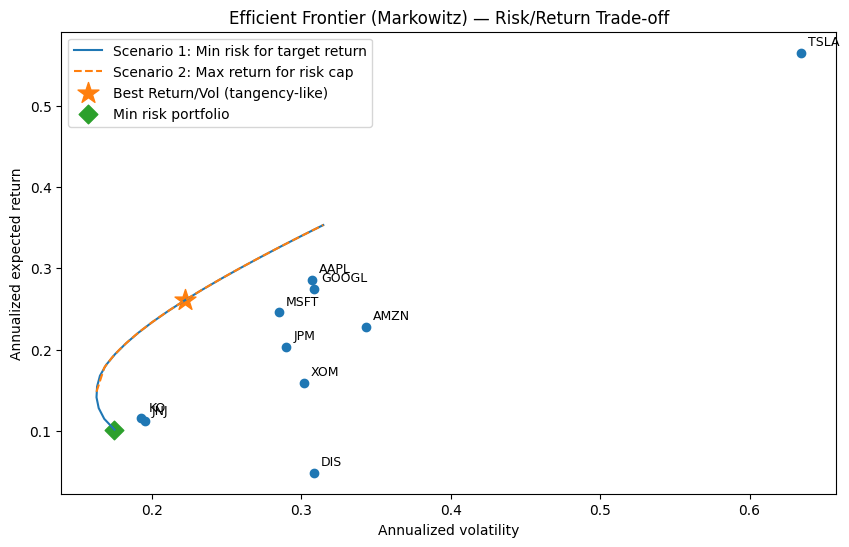

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# frontier_df: scenario 1 con colonne ["vol","ret"]
# frontier2_df: scenario 2 con colonne ["vol","ret"]
# summary_stats: dataframe con colonne ["Exp Return (ann.)","Volatility (ann.)"]

fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# Frontiere
ax.plot(frontier_df["vol"], frontier_df["ret"], label="Scenario 1: Min risk for target return")
ax.plot(frontier2_df["vol"], frontier2_df["ret"], linestyle="--", label="Scenario 2: Max return for risk cap")

# Singoli asset
ax.scatter(summary_stats["Volatility (ann.)"], summary_stats["Exp Return (ann.)"])
for t in summary_stats.index:
    ax.annotate(t, (summary_stats.loc[t,"Volatility (ann.)"], summary_stats.loc[t,"Exp Return (ann.)"]),
                xytext=(5,5), textcoords="offset points", fontsize=9)

# Highlight: best ret/vol (w_best che hai già)
ax.scatter([port_vol(w_best)], [port_return(w_best)], marker="*", s=250, label="Best Return/Vol (tangency-like)")

# Highlight: min variance (puoi usare il primo punto della frontiera 1 se è quello a rischio min)
w_minrisk = weights_list[0]  # se weights_list è allineata a frontier_df
ax.scatter([port_vol(w_minrisk)], [port_return(w_minrisk)], marker="D", s=90, label="Min risk portfolio")

ax.set_xlabel("Annualized volatility")
ax.set_ylabel("Annualized expected return")
ax.set_title("Efficient Frontier (Markowitz) — Risk/Return Trade-off")
ax.legend()
plt.show()

In [15]:
import pandas as pd

def weights_table(w, tickers, top_n=10):
    s = pd.Series(w, index=tickers).sort_values(ascending=False)
    s = s[s > 1e-6]
    return s.head(top_n).to_frame("weight")

tickers = summary_stats.index.tolist()

tab_best = weights_table(w_best, tickers, top_n=10)
tab_minrisk = weights_table(w_minrisk, tickers, top_n=10)

print("Best Return/Vol weights:")
display(tab_best)

print("Min risk weights:")
display(tab_minrisk)

Best Return/Vol weights:


,weight
AMZN,0.198941
MSFT,0.194666
JNJ,0.168130
TSLA,0.168057
XOM,0.133592
DIS,0.059797
JPM,0.050561
KO,0.026256


Min risk weights:


,weight
XOM,0.300000
AMZN,0.300000
GOOGL,0.290799
DIS,0.081783
AAPL,0.027418


In [65]:
# STEP 1 — sanity check: cosa esiste in memoria?
for name in ["prices", "mu_ann", "cov_ann", "CAP", "ALLOW_SHORT"]:
    print(name, "OK" if name in globals() else "MISSING")

# check dimensioni se esistono
if "prices" in globals():
    print("prices shape:", prices.shape)
if "mu_ann" in globals():
    print("mu_ann len:", len(mu_ann))
if "cov_ann" in globals():
    print("cov_ann shape:", cov_ann.shape)

prices OK
mu_ann OK
cov_ann OK
CAP OK
ALLOW_SHORT OK
prices shape: (2034, 10)
mu_ann len: 10
cov_ann shape: (10, 10)


In [29]:
# STEP 2 — returns + annualizzazione (robusto)
import numpy as np
import pandas as pd

# usa Adj Close; se hai un altro df chiamato diverso, adattalo
rets_daily = prices.pct_change().dropna()

TRADING_DAYS = 252
mu_ann = rets_daily.mean() * TRADING_DAYS
cov_ann = rets_daily.cov() * TRADING_DAYS

print("rets_daily:", rets_daily.shape)
print("mu_ann:", mu_ann.shape, "NaN:", mu_ann.isna().sum())
print("cov_ann:", cov_ann.shape, "NaN:", cov_ann.isna().sum().sum())

rets_daily: (2033, 10)
mu_ann: (10,) NaN: 0
cov_ann: (10, 10) NaN: 0


In [30]:
# STEP 3 — Range “fattibile” della volatilità
ALLOW_SHORT = False   # long-only per Markowitz base
CAP = 0.30            # max 30% per asset (se vuoi evitare concentrazione)
def solve_min_vol(mu, cov, cap=None, allow_short=False):
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)
    cons = ({"type":"eq", "fun": lambda w: np.sum(w)-1.0},)
    obj = lambda w: port_vol(w, cov)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

def solve_max_vol(mu, cov, cap=None, allow_short=False):
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)
    cons = ({"type":"eq", "fun": lambda w: np.sum(w)-1.0},)
    obj = lambda w: -port_vol(w, cov)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

res_minv = solve_min_vol(mu_ann.values, cov_ann.values, cap=CAP, allow_short=ALLOW_SHORT)
res_maxv = solve_max_vol(mu_ann.values, cov_ann.values, cap=CAP, allow_short=ALLOW_SHORT)

v_min = port_vol(res_minv.x, cov_ann.values)
v_max = port_vol(res_maxv.x, cov_ann.values)

print("Feasible vol range:", v_min, "->", v_max)

Feasible vol range: 0.16294732166385945 -> 0.3353124835174051


In [32]:
# STEP 4 — Frontiera efficiente completa (Scenario 1 + Scenario 2) con pesi
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- helpers ---
def _bounds(n, cap=None, allow_short=False):
    if allow_short:
        return [(-1.0, 1.0)]*n if cap is None else [(-cap, cap)]*n
    return [(0.0, 1.0)]*n if cap is None else [(0.0, cap)]*n

def port_ret(w, mu):
    return float(np.dot(w, mu))

def port_vol(w, cov):
    return float(np.sqrt(w @ cov @ w))

# --- solvers base: min/max volatility (serve per range fattibile di Scenario 2) ---
def solve_min_vol(mu, cov, cap=None, allow_short=False):
    mu = np.array(mu); cov = np.array(cov)
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)
    cons = ({"type":"eq", "fun": lambda w: np.sum(w) - 1.0},)
    obj = lambda w: port_vol(w, cov)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

def solve_max_vol(mu, cov, cap=None, allow_short=False):
    mu = np.array(mu); cov = np.array(cov)
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)
    cons = ({"type":"eq", "fun": lambda w: np.sum(w) - 1.0},)
    obj = lambda w: -port_vol(w, cov)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

# --- Scenario 1: min vol per target return ---
def solve_min_vol_for_target_ret(mu, cov, target_ret, cap=None, allow_short=False):
    mu = np.array(mu); cov = np.array(cov)
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)

    cons = (
        {"type":"eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type":"eq", "fun": lambda w: port_ret(w, mu) - target_ret},
    )

    obj = lambda w: port_vol(w, cov)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

# --- Scenario 2: max return per risk cap (vol <= cap) ---
def solve_max_ret_for_risk_cap(mu, cov, risk_cap, cap=None, allow_short=False):
    mu = np.array(mu); cov = np.array(cov)
    n = len(mu)
    x0 = np.ones(n)/n
    bnds = _bounds(n, cap, allow_short)

    cons = (
        {"type":"eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type":"ineq", "fun": lambda w: risk_cap - port_vol(w, cov)},
    )

    obj = lambda w: -port_ret(w, mu)
    return minimize(obj, x0, method="SLSQP", bounds=bnds, constraints=cons)

# --- Efficient frontier: S1 + S2 (con controllo fattibilità) ---
def efficient_frontier(mu, cov, cap=None, allow_short=False, n_points=60):
    mu = np.array(mu); cov = np.array(cov)
    rows = []

    # Scenario 1: target returns in a feasible band
    r_min, r_max = mu.min(), mu.max()
    target_rets = np.linspace(r_min, r_max, n_points)

    for tr in target_rets:
        res = solve_min_vol_for_target_ret(mu, cov, tr, cap=cap, allow_short=allow_short)
        if res.success:
            w = res.x
            rows.append({
                "scenario": "S1_min_vol_for_ret",
                "target_ret": tr,
                "vol": port_vol(w, cov),
                "ret": port_ret(w, mu),
                "weights": w
            })

    # Scenario 2: scan risk caps only in feasible volatility range
    res_minv = solve_min_vol(mu, cov, cap=cap, allow_short=allow_short)
    res_maxv = solve_max_vol(mu, cov, cap=cap, allow_short=allow_short)

    if (not res_minv.success) or (not res_maxv.success):
        raise RuntimeError("Min/Max volatility optimization failed (check constraints/cap).")

    v_min = port_vol(res_minv.x, cov)
    v_max = port_vol(res_maxv.x, cov)

    risk_caps = np.linspace(v_min, v_max, n_points)

    for vc in risk_caps:
        res = solve_max_ret_for_risk_cap(mu, cov, vc, cap=cap, allow_short=allow_short)
        if res.success:
            w = res.x
            rows.append({
                "scenario": "S2_max_ret_for_vol",
                "target_vol": vc,
                "vol": port_vol(w, cov),
                "ret": port_ret(w, mu),
                "weights": w
            })

    return pd.DataFrame(rows)

# ---- RUN ----
ef = efficient_frontier(mu_ann.values, cov_ann.values, cap=CAP, allow_short=ALLOW_SHORT, n_points=60)
ef.head()

,scenario,target_ret,vol,ret,weights,target_vol
0,S1_min_vol_for_ret,0.100925,0.175338,0.100925,"[1.0321604682062002e-16, 0.025564026640850883,...",NaN
1,S1_min_vol_for_ret,0.109689,0.170391,0.109689,"[0.0, 0.06198952099623599, 0.2373516168499206,...",NaN
2,S1_min_vol_for_ret,0.118453,0.166838,0.118453,"[0.0, 0.09842623277375753, 0.1810130911365852,...",NaN
3,S1_min_vol_for_ret,0.127216,0.164608,0.127216,"[0.0, 0.10754474961571024, 0.13225162337565563...",NaN
4,S1_min_vol_for_ret,0.135980,0.163343,0.135980,"[4.065758146820642e-18, 0.1066081669093203, 0....",NaN


In [34]:
print(ef["scenario"].value_counts())
print("Vol range:", ef["vol"].min(), "->", ef["vol"].max())
print("Ret range:", ef["ret"].min(), "->", ef["ret"].max())

scenario
S2_max_ret_for_vol    60
S1_min_vol_for_ret    30
Name: count, dtype: int64
Vol range: 0.16294732176508503 -> 0.3267321058390192
Ret range: 0.10092521332373325 -> 0.36246740471181293


In [25]:
#STEP 5 — “Portafoglio ottimale” fatto bene: tangency con risk-free (Sharpe)
RF = 0.03  # 3% annuo

def solve_max_sharpe(mu, cov, rf=0.0, cap=None, allow_short=False):
    mu = np.array(mu); cov=np.array(cov)
    n=len(mu)
    x0=np.ones(n)/n
    bnds=_bounds(n, cap, allow_short)
    cons=({"type":"eq","fun":lambda w: np.sum(w)-1.0},)

    def neg_sharpe(w):
        r = port_ret(w, mu)
        v = port_vol(w, cov)
        return -((r - rf) / v)

    return minimize(neg_sharpe, x0, method="SLSQP", bounds=bnds, constraints=cons)

res_sh = solve_max_sharpe(mu_ann.values, cov_ann.values, rf=RF, cap=CAP, allow_short=ALLOW_SHORT)
w_sh = res_sh.x
print("Sharpe-opt vol/ret:", port_vol(w_sh,cov_ann.values), port_ret(w_sh,mu_ann.values),
      "Sharpe:", (port_ret(w_sh,mu_ann.values)-RF)/port_vol(w_sh,cov_ann.values))

Sharpe-opt vol/ret: 0.24685314717093917 0.2876067657930484 Sharpe: 1.0435628175915563


In [33]:
# STEP 6 — Backtest semplice (out-of-sample)
split_date = "2024-01-01"
rets_train = rets_d.loc[:split_date].copy()
rets_test  = rets_d.loc[split_date:].copy()

mu_tr = rets_train.mean()*TRADING_DAYS
cov_tr = rets_train.cov()*TRADING_DAYS

# pesi ottimali su train
res_sh_tr = solve_max_sharpe(mu_tr.values, cov_tr.values, rf=RF, cap=CAP, allow_short=ALLOW_SHORT)
w_sh_tr = res_sh_tr.x
w_eq = np.ones(len(tickers))/len(tickers)

def portfolio_series(returns, w):
    return returns.values @ w

p_test_sh = portfolio_series(rets_test, w_sh_tr)
p_test_eq = portfolio_series(rets_test, w_eq)

def perf_stats(r, rf_daily=0.0):
    r = np.asarray(r)
    ann_ret = (1+r).prod()**(TRADING_DAYS/len(r)) - 1
    ann_vol = np.std(r)*np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - RF)/ann_vol
    mdd = (np.maximum.accumulate((1+r).cumprod()) - (1+r).cumprod()).max()
    return ann_ret, ann_vol, sharpe, mdd

print("TEST Sharpe-opt:", perf_stats(p_test_sh))
print("TEST Equal-wt  :", perf_stats(p_test_eq))

TEST Sharpe-opt: (np.float64(0.22231867790342008), np.float64(0.27575417216138237), np.float64(0.6974279895604535), np.float64(0.4910668531275819))
TEST Equal-wt  : (np.float64(0.2769075257500624), np.float64(0.16547703867391803), np.float64(1.492095385128373), np.float64(0.2696293654649604))


In [35]:
# STEP 7 - Backtest out-of-sample + confronto con baseline
import numpy as np
import pandas as pd

TRADING_DAYS = 252

def portfolio_returns(returns_df, w):
    w = np.asarray(w).reshape(-1)
    return returns_df.values @ w

def perf_stats(port_rets):
    port_rets = pd.Series(port_rets).dropna()
    wealth = (1 + port_rets).cumprod()
    cagr = wealth.iloc[-1]**(TRADING_DAYS/len(port_rets)) - 1
    vol = port_rets.std() * np.sqrt(TRADING_DAYS)
    sharpe = (port_rets.mean() * TRADING_DAYS) / vol if vol > 0 else np.nan
    dd = wealth / wealth.cummax() - 1
    max_dd = dd.min()
    return {"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "MaxDD": max_dd}

# --- 1) Split temporale
train_end = "2023-12-29"
test_start = "2024-01-02"

rets_daily = prices.pct_change().dropna()
rets_tr = rets_daily.loc[:train_end]
rets_te = rets_daily.loc[test_start:]

mu_tr = rets_tr.mean() * TRADING_DAYS
cov_tr = rets_tr.cov() * TRADING_DAYS

print("Train:", rets_tr.index.min().date(), "->", rets_tr.index.max().date(), "| n=", len(rets_tr))
print("Test :", rets_te.index.min().date(), "->", rets_te.index.max().date(), "| n=", len(rets_te))

# --- 2) Pesi: min-variance e "Sharpe-like" (max ret/vol) su TRAIN
# usa le tue funzioni già definite: solve_min_vol / solve_max_retvol (o come le hai chiamate)
w_minvar = solve_min_vol(mu_tr.values, cov_tr.values, cap=CAP, allow_short=ALLOW_SHORT).x

# se hai la funzione per best ret/vol (tangency-like) usala:
# esempio: res_best = solve_max_ret_over_vol(mu_tr.values, cov_tr.values, cap=CAP, allow_short=ALLOW_SHORT)
# altrimenti prendilo dalla tua efficient frontier calcolata su TRAIN:
ef_tr = efficient_frontier(mu_tr.values, cov_tr.values, cap=CAP, allow_short=ALLOW_SHORT, n_points=60)
best_tr = ef_tr.loc[ef_tr["scenario"].str.contains("S2_max_ret_for_vol")].copy()
best_tr["ratio"] = best_tr["ret"]/best_tr["vol"]
row_best = best_tr.sort_values("ratio", ascending=False).iloc[0]
w_sharpe_like = np.array(row_best["weights"])

# baseline equal-weight
n = rets_daily.shape[1]
w_eq = np.ones(n) / n

# --- 3) Backtest su TEST
bt = {}
bt["MinVar (train->test)"] = perf_stats(portfolio_returns(rets_te, w_minvar))
bt["Sharpe-like (train->test)"] = perf_stats(portfolio_returns(rets_te, w_sharpe_like))
bt["Equal-weight (test)"] = perf_stats(portfolio_returns(rets_te, w_eq))

results = pd.DataFrame(bt).T.sort_values("Sharpe", ascending=False)
results

Train: 2018-01-03 -> 2023-12-29 | n= 1508
Test : 2024-01-02 -> 2026-02-04 | n= 525


,CAGR,Vol,Sharpe,MaxDD
MinVar (train->test),0.246720,0.110150,2.057838,-0.106495
Equal-weight (test),0.276908,0.165635,1.558736,-0.200059
Sharpe-like (train->test),0.215640,0.249227,0.907103,-0.304004


In [36]:
# STEP 8 - CONTROLLI DI ROBUSTEZZA
tickers = list(rets_daily.columns)

def weight_report(w, name):
    w = pd.Series(w, index=tickers).sort_values(ascending=False)
    herf = float((w**2).sum())
    n_active = int((w.abs() > 0.01).sum())
    print("\n==", name, "==")
    print(w[w.abs() > 1e-4])
    print(f"Herfindahl: {herf:.3f} | Active(>1%): {n_active}/{len(w)} | Sum: {w.sum():.6f}")
    return w

w_minvar_s = weight_report(w_minvar, "MinVar (train)")
w_sharpe_s = weight_report(w_sharpe_like, "Sharpe-like (train)")
w_eq_s     = weight_report(w_eq, "Equal-weight")


== MinVar (train) ==
KO       0.300000
JNJ      0.300000
XOM      0.129710
AMZN     0.127315
DIS      0.062574
GOOGL    0.046887
JPM      0.019362
AAPL     0.014152
dtype: float64
Herfindahl: 0.220 | Active(>1%): 8/10 | Sum: 1.000000

== Sharpe-like (train) ==
AAPL    0.300000
MSFT    0.300000
TSLA    0.252094
KO      0.099904
XOM     0.048002
dtype: float64
Herfindahl: 0.256 | Active(>1%): 5/10 | Sum: 1.000000

== Equal-weight ==
AAPL     0.1
AMZN     0.1
DIS      0.1
GOOGL    0.1
JNJ      0.1
JPM      0.1
KO       0.1
MSFT     0.1
TSLA     0.1
XOM      0.1
dtype: float64
Herfindahl: 0.100 | Active(>1%): 10/10 | Sum: 1.000000


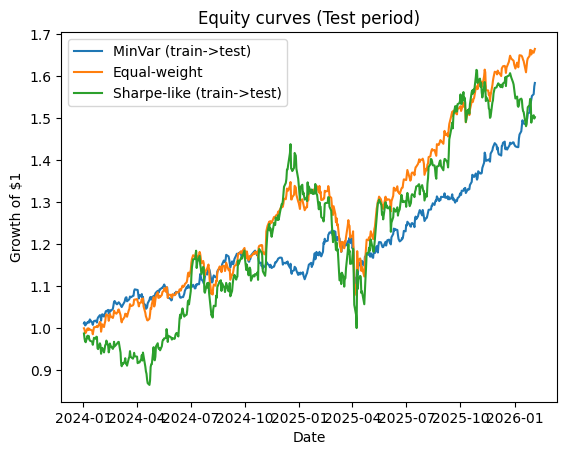

In [37]:
import matplotlib.pyplot as plt

def equity_curve(returns):
    returns = pd.Series(returns, index=rets_te.index).dropna()
    return (1 + returns).cumprod()

eq_minvar = equity_curve(portfolio_returns(rets_te, w_minvar))
eq_sharpe = equity_curve(portfolio_returns(rets_te, w_sharpe_like))
eq_eq     = equity_curve(portfolio_returns(rets_te, w_eq))

plt.figure()
plt.plot(eq_minvar, label="MinVar (train->test)")
plt.plot(eq_eq, label="Equal-weight")
plt.plot(eq_sharpe, label="Sharpe-like (train->test)")
plt.legend()
plt.title("Equity curves (Test period)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.show()

In [38]:
# 1) correlazione media test
corr_te = rets_te.corr()
avg_corr = (corr_te.values[np.triu_indices_from(corr_te.values, k=1)]).mean()
print("Avg pairwise corr (test):", round(float(avg_corr), 3))

# 2) risk contribution (test covariance)
cov_te = rets_te.cov() * 252
w = np.asarray(w_minvar).reshape(-1,1)
port_var = float(w.T @ cov_te.values @ w)
marginal = (cov_te.values @ w) / np.sqrt(port_var)
contrib = (w * marginal).flatten()
rc = pd.Series(contrib, index=tickers).sort_values(ascending=False)
rc = rc / rc.sum()

print("\nRisk contributions (MinVar, on TEST cov):")
print(rc.head(10))

Avg pairwise corr (test): 0.21

Risk contributions (MinVar, on TEST cov):
JNJ      3.050357e-01
KO       2.600258e-01
AMZN     1.482222e-01
XOM      1.349869e-01
DIS      7.650831e-02
GOOGL    3.988659e-02
JPM      1.948935e-02
AAPL     1.584508e-02
MSFT     1.140995e-17
TSLA     0.000000e+00
dtype: float64


/tmp/ipython-input-965520669.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  port_var = float(w.T @ cov_te.values @ w)


In [39]:
port_var = float((w.T @ cov_te.values @ w).item())

In [49]:
# STEP 9: “walk-forward” + rolling weights
import numpy as np
import pandas as pd

def walk_forward_minvar(rets_daily, lookback_days=756, rebalance='ME', cap=0.30, allow_short=False):
    rets = rets_daily.dropna().copy()

    # Date di rebalance: fine periodo (Month-End)
    # .last() restituisce le righe di fine mese; l'index sono le date che ci servono
    reb_dates = rets.resample(rebalance).last().index
    reb_dates = reb_dates[reb_dates.isin(rets.index)]  # sicurezza

    weights_hist = []
    port_rets = pd.Series(index=rets.index, dtype=float)

    tickers = list(rets.columns)

    for i in range(len(reb_dates) - 1):
        d = reb_dates[i]
        next_d = reb_dates[i + 1]

        # finestra lookback che termina in d
        end_loc = rets.index.get_loc(d)
        start_loc = max(0, end_loc - lookback_days)
        window = rets.iloc[start_loc:end_loc + 1]

        mu = (1 + window.mean())**252 - 1
        cov = window.cov() * 252

        # ottimizza MinVar (assumo solve_min_vol esista già nel tuo notebook)
        res = solve_min_vol(mu.values, cov.values, cap=cap, allow_short=allow_short)
        w = np.asarray(res.x, dtype=float)

        weights_hist.append(pd.Series(w, index=tickers, name=d))

        # applica pesi al periodo successivo (d, next_d]
        mask = (rets.index > d) & (rets.index <= next_d)
        port_rets.loc[mask] = rets.loc[mask].values @ w

    weights_hist = pd.DataFrame(weights_hist)
    return port_rets.dropna(), weights_hist

# run
wf_rets_minvar, wf_w_minvar = walk_forward_minvar(
    rets_daily, lookback_days=756, rebalance='ME', cap=CAP, allow_short=ALLOW_SHORT
)

# Equal-weight benchmark (stesso indice temporale del wf)
w_eq = np.ones(rets_daily.shape[1]) / rets_daily.shape[1]
wf_rets_eq = pd.Series(
    rets_daily.loc[wf_rets_minvar.index].values @ w_eq,
    index=wf_rets_minvar.index
)

print("Walk-forward done:", "MinVar n=", len(wf_rets_minvar), "| Eq n=", len(wf_rets_eq))
print("Rebalance points:", len(wf_w_minvar))

Walk-forward done: MinVar n= 1990 | Eq n= 1990
Rebalance points: 67


In [42]:
print(wf_w_minvar.head(3))
print("Weights sum (first rows):", wf_w_minvar.sum(axis=1).head().values)
print("Any NaN weights?", wf_w_minvar.isna().any().any())

                AAPL      AMZN       DIS         GOOGL       JNJ  \
2018-01-31  0.057149  0.245924  0.000000  1.051924e-02  0.097032   
2018-02-28  0.045424  0.253733  0.110028  5.637851e-18  0.119736   
2018-04-30  0.035323  0.068317  0.300000  2.284278e-17  0.132072   

                     JPM        KO          MSFT          TSLA           XOM  
2018-01-31  2.441808e-01  0.269134  0.000000e+00  7.606040e-02  1.238518e-17  
2018-02-28  4.336809e-18  0.300000  4.943962e-17  5.724587e-17  1.710788e-01  
2018-04-30  2.005774e-17  0.300000  0.000000e+00  2.954451e-17  1.642875e-01  
Weights sum (first rows): [1. 1. 1. 1. 1.]
Any NaN weights? False


In [44]:
# Turnover (L1): somma delle variazioni assolute dei pesi ad ogni rebalance
wf_w_minvar = wf_w_minvar.sort_index()

turnover = wf_w_minvar.diff().abs().sum(axis=1).dropna()
print("Turnover (per rebalance) summary:")
print(turnover.describe())

# Annualizzazione (circa 12 rebalance/anno se monthly)
turnover_ann = turnover.mean() * 12
print(f"\nAvg turnover per rebalance: {turnover.mean():.3f}")
print(f"Approx annual turnover (x12): {turnover_ann:.3f}")

Turnover (per rebalance) summary:
count    67.000000
mean      0.071860
std       0.120414
min       0.000000
25%       0.020394
50%       0.033433
75%       0.060410
max       0.684971
dtype: float64

Avg turnover per rebalance: 0.072
Approx annual turnover (x12): 0.862


In [45]:
# 1) data del picco
peak_date = turnover.idxmax()
print("Peak turnover date:", peak_date, "value:", turnover.loc[peak_date])

# 2) quali asset hanno guidato il cambio
delta = wf_w_minvar.diff().abs().loc[peak_date].sort_values(ascending=False)
print("\nTop weight changes at peak:")
print(delta.head(10))

# 3) snapshot pesi prima/dopo
prev_date = wf_w_minvar.index[wf_w_minvar.index.get_loc(peak_date) - 1]
print("\nWeights previous rebalance:")
print(wf_w_minvar.loc[prev_date].sort_values(ascending=False).head(10))
print("\nWeights at peak rebalance:")
print(wf_w_minvar.loc[peak_date].sort_values(ascending=False).head(10))

Peak turnover date: 2018-02-28 00:00:00 value: 0.6849713795379129

Top weight changes at peak:
JPM      2.441808e-01
XOM      1.710788e-01
DIS      1.100284e-01
TSLA     7.606040e-02
KO       3.086598e-02
JNJ      2.270418e-02
AAPL     1.172527e-02
GOOGL    1.051924e-02
AMZN     7.808343e-03
MSFT     4.943962e-17
Name: 2018-02-28 00:00:00, dtype: float64

Weights previous rebalance:
KO       2.691340e-01
AMZN     2.459243e-01
JPM      2.441808e-01
JNJ      9.703191e-02
TSLA     7.606040e-02
AAPL     5.714935e-02
GOOGL    1.051924e-02
XOM      1.238518e-17
DIS      0.000000e+00
MSFT     0.000000e+00
Name: 2018-01-31 00:00:00, dtype: float64

Weights at peak rebalance:
KO       3.000000e-01
AMZN     2.537326e-01
XOM      1.710788e-01
JNJ      1.197361e-01
DIS      1.100284e-01
AAPL     4.542408e-02
TSLA     5.724587e-17
MSFT     4.943962e-17
GOOGL    5.637851e-18
JPM      4.336809e-18
Name: 2018-02-28 00:00:00, dtype: float64


In [52]:
from sklearn.covariance import LedoitWolf
import pandas as pd

def cov_ledoitwolf(rets_window: pd.DataFrame) -> pd.DataFrame:
    lw = LedoitWolf().fit(rets_window.values)
    return pd.DataFrame(lw.covariance_, index=rets_window.columns, columns=rets_window.columns)

In [47]:
# test rapido su una finestra
test_window = rets_daily.iloc[:756]   # o la tua lookback
cov_test = cov_ledoitwolf(test_window) * 252
print(cov_test.shape)
print(np.isfinite(cov_test.values).all())
print(cov_test.iloc[:3,:3])

(10, 10)
True
Ticker      AAPL      AMZN       DIS
Ticker                              
AAPL    0.123487  0.074365  0.055002
AMZN    0.074365  0.110905  0.038472
DIS     0.055002  0.038472  0.111959


In [53]:
import numpy as np
import pandas as pd

# 1) Daily returns
rets_daily = prices.pct_change().dropna()

# 2) Annualized expected returns (mean * 252)
mu_ann = rets_daily.mean() * 252

# 3) Annualized covariance via Ledoit–Wolf (shrinkage)
cov_ann = cov_ledoitwolf(rets_daily) * 252

# 4) Sanity checks
print("rets_daily:", rets_daily.shape, "| NaN:", rets_daily.isna().sum().sum())
print("mu_ann:", mu_ann.shape, "| NaN:", mu_ann.isna().sum())
print("cov_ann:", cov_ann.shape, "| finite:", np.isfinite(cov_ann.values).all())

display(mu_ann.sort_values(ascending=False).to_frame("Exp Return (ann.)").head(10))
display(cov_ann.iloc[:5, :5])

rets_daily: (2033, 10) | NaN: 0
mu_ann: (10,) | NaN: 0
cov_ann: (10, 10) | finite: True


,Exp Return (ann.)
Ticker,
TSLA,0.565399
AAPL,0.285812
GOOGL,0.274984
MSFT,0.246089
AMZN,0.228272
JPM,0.203329
XOM,0.159271
KO,0.115302
JNJ,0.111472


Ticker,AAPL,AMZN,DIS,GOOGL,JNJ
Ticker,,,,,
AAPL,0.094552,0.061753,0.040808,0.058330,0.018969
AMZN,0.061753,0.117870,0.042326,0.067104,0.010359
DIS,0.040808,0.042326,0.095237,0.039834,0.015729
GOOGL,0.058330,0.067104,0.039834,0.095466,0.015304
JNJ,0.018969,0.010359,0.015729,0.015304,0.038927


In [54]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- constraints helpers ---
def port_ret(w, mu):
    return float(np.dot(w, mu))

def port_var(w, cov):
    return float(w.T @ cov @ w)

def port_vol(w, cov):
    return np.sqrt(port_var(w, cov))

def bounds_for_assets(n, cap=0.30, allow_short=False):
    if allow_short:
        # se vuoi short, puoi mettere bound più larghi (es. -cap..cap oppure None..None)
        return [(-cap, cap) for _ in range(n)]
    else:
        return [(0.0, cap) for _ in range(n)]

def solve_min_var(mu, cov, target_ret, cap=0.30, allow_short=False):
    n = len(mu)
    w0 = np.ones(n) / n
    bnds = bounds_for_assets(n, cap=cap, allow_short=allow_short)

    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type": "eq", "fun": lambda w: np.dot(w, mu) - target_ret},
    ]

    res = minimize(lambda w: port_var(w, cov),
                   w0, method="SLSQP", bounds=bnds, constraints=cons)
    return res

def solve_max_ret(mu, cov, target_vol, cap=0.30, allow_short=False):
    n = len(mu)
    w0 = np.ones(n) / n
    bnds = bounds_for_assets(n, cap=cap, allow_short=allow_short)

    cons = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
        {"type": "ineq", "fun": lambda w: target_vol - port_vol(w, cov)},  # vol(w) <= target_vol
    ]

    # max return <=> min(-return)
    res = minimize(lambda w: -port_ret(w, mu),
                   w0, method="SLSQP", bounds=bnds, constraints=cons)
    return res

def solve_global_min_var(mu, cov, cap=0.30, allow_short=False):
    n = len(mu)
    w0 = np.ones(n) / n
    bnds = bounds_for_assets(n, cap=cap, allow_short=allow_short)
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    res = minimize(lambda w: port_var(w, cov),
                   w0, method="SLSQP", bounds=bnds, constraints=cons)
    return res

def solve_max_return(mu, cov, cap=0.30, allow_short=False):
    n = len(mu)
    w0 = np.ones(n) / n
    bnds = bounds_for_assets(n, cap=cap, allow_short=allow_short)
    cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    res = minimize(lambda w: -port_ret(w, mu),
                   w0, method="SLSQP", bounds=bnds, constraints=cons)
    return res

# =========================
# STEP 2 — Efficient frontier (Scenario 1 + 2)
# =========================
CAP = 0.30
ALLOW_SHORT = False

mu = mu_ann.values
cov = cov_ann.values
tickers = mu_ann.index.tolist()

# Feasible extremes under constraints
res_gmv = solve_global_min_var(mu, cov, cap=CAP, allow_short=ALLOW_SHORT)
res_maxr = solve_max_return(mu, cov, cap=CAP, allow_short=ALLOW_SHORT)

if not (res_gmv.success and res_maxr.success):
    print("GMV success:", res_gmv.success, res_gmv.message)
    print("MaxR success:", res_maxr.success, res_maxr.message)
    raise RuntimeError("Ottimizzazione estremi non riuscita: controllare vincoli/cap.")

v_min = port_vol(res_gmv.x, cov)
r_at_vmin = port_ret(res_gmv.x, mu)
v_at_maxr = port_vol(res_maxr.x, cov)
r_max = port_ret(res_maxr.x, mu)

print(f"Feasible vol range: {v_min:.4f} -> {v_at_maxr:.4f}")
print(f"Feasible ret range: {r_at_vmin:.4f} -> {r_max:.4f}")

# Build grid on returns for Scenario 1 (min vol per target return)
n_points = 30
target_rets = np.linspace(r_at_vmin, r_max, n_points)

rows = []
for tr in target_rets:
    res = solve_min_var(mu, cov, target_ret=float(tr), cap=CAP, allow_short=ALLOW_SHORT)
    if res.success:
        w = res.x
        rows.append({
            "scenario": "S1_min_vol_for_ret",
            "target_ret": float(tr),
            "vol": port_vol(w, cov),
            "ret": port_ret(w, mu),
            "weights": w
        })

# Build grid on vols for Scenario 2 (max ret per target vol)
n_points2 = 60
target_vols = np.linspace(v_min, v_at_maxr, n_points2)

for tv in target_vols:
    res = solve_max_ret(mu, cov, target_vol=float(tv), cap=CAP, allow_short=ALLOW_SHORT)
    if res.success:
        w = res.x
        rows.append({
            "scenario": "S2_max_ret_for_vol",
            "target_vol": float(tv),
            "vol": port_vol(w, cov),
            "ret": port_ret(w, mu),
            "weights": w
        })

ef = pd.DataFrame(rows)

print(ef["scenario"].value_counts())
print("EF vol range:", ef["vol"].min(), "->", ef["vol"].max())
print("EF ret range:", ef["ret"].min(), "->", ef["ret"].max())

# Quick: pick best return/vol (proxy Sharpe without rf)
ef["ret_over_vol"] = ef["ret"] / ef["vol"]
best = ef.loc[ef["ret_over_vol"].idxmax()]
print("\nBest (ret/vol) vol:", best["vol"])
print("Best (ret/vol) ret:", best["ret"])
print("Best (ret/vol) ratio:", best["ret_over_vol"])

best_w = pd.Series(best["weights"], index=tickers).sort_values(ascending=False)
display(best_w[best_w > 1e-6].to_frame("weight"))

Feasible vol range: 0.1628 -> 0.3256
Feasible ret range: 0.1447 -> 0.3625
scenario
S2_max_ret_for_vol    60
S1_min_vol_for_ret    30
Name: count, dtype: int64
EF vol range: 0.16284901997294665 -> 0.3255679868335549
EF ret range: 0.1447182538130495 -> 0.36246740471181293

Best (ret/vol) vol: 0.21800831085648015
Best (ret/vol) ret: 0.256648048895682
Best (ret/vol) ratio: 1.1772397478215373


,weight
JNJ,0.201726
GOOGL,0.188623
TSLA,0.161705
AAPL,0.161652
KO,0.138912
XOM,0.061728
JPM,0.052939
MSFT,0.032717


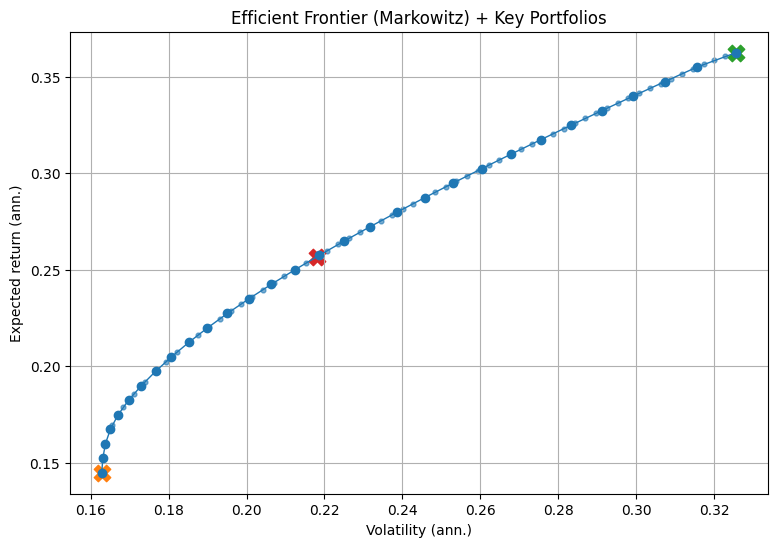

GMV      vol/ret: 0.16284901827399653 0.1447182538139926
MaxRet   vol/ret: 0.3255679868335549 0.36246740471181293
BestRV   vol/ret: 0.21800831085648015 0.256648048895682


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- ricostruisco anche i due estremi per plottarli (se non li hai in memoria) ---
def solve_global_min_var(mu, cov, cap=0.30, allow_short=False):
    from scipy.optimize import minimize
    n = len(mu)
    w0 = np.ones(n)/n
    bnds = [(0.0, cap) for _ in range(n)] if not allow_short else [(-cap, cap) for _ in range(n)]
    cons = [{"type":"eq","fun": lambda w: np.sum(w)-1.0}]
    return minimize(lambda w: float(w.T@cov@w), w0, method="SLSQP", bounds=bnds, constraints=cons)

def solve_max_return(mu, cov, cap=0.30, allow_short=False):
    from scipy.optimize import minimize
    n = len(mu)
    w0 = np.ones(n)/n
    bnds = [(0.0, cap) for _ in range(n)] if not allow_short else [(-cap, cap) for _ in range(n)]
    cons = [{"type":"eq","fun": lambda w: np.sum(w)-1.0}]
    return minimize(lambda w: -float(np.dot(w, mu)), w0, method="SLSQP", bounds=bnds, constraints=cons)

def port_ret(w, mu): return float(np.dot(w, mu))
def port_vol(w, cov): return float(np.sqrt(w.T @ cov @ w))

CAP = 0.30
ALLOW_SHORT = False

mu = mu_ann.values
cov = cov_ann.values

# special portfolios
res_gmv = solve_global_min_var(mu, cov, cap=CAP, allow_short=ALLOW_SHORT)
res_maxr = solve_max_return(mu, cov, cap=CAP, allow_short=ALLOW_SHORT)

gmv_vol, gmv_ret = port_vol(res_gmv.x, cov), port_ret(res_gmv.x, mu)
maxr_vol, maxr_ret = port_vol(res_maxr.x, cov), port_ret(res_maxr.x, mu)

# best ret/vol già trovato in precedenza come "best"
best_vol, best_ret = float(best["vol"]), float(best["ret"])

# --- plot ---
plt.figure(figsize=(9,6))

# usa una sola serie per pulizia (S1 è già la frontiera "classica")
ef_s1 = ef[ef["scenario"]=="S1_min_vol_for_ret"].sort_values("vol")
plt.plot(ef_s1["vol"], ef_s1["ret"], marker="o", linewidth=1)

# opzionale: anche S2 (di solito coincide/sovrappone)
ef_s2 = ef[ef["scenario"]=="S2_max_ret_for_vol"].sort_values("vol")
plt.scatter(ef_s2["vol"], ef_s2["ret"], s=12, alpha=0.6)

# punti speciali
plt.scatter([gmv_vol],[gmv_ret], marker="X", s=140)
plt.scatter([maxr_vol],[maxr_ret], marker="X", s=140)
plt.scatter([best_vol],[best_ret], marker="X", s=140)

plt.xlabel("Volatility (ann.)")
plt.ylabel("Expected return (ann.)")
plt.title("Efficient Frontier (Markowitz) + Key Portfolios")
plt.grid(True)
plt.show()

# stampo i numeri (per poi usarli nel report dopo)
print("GMV      vol/ret:", gmv_vol, gmv_ret)
print("MaxRet   vol/ret:", maxr_vol, maxr_ret)
print("BestRV   vol/ret:", best_vol, best_ret)

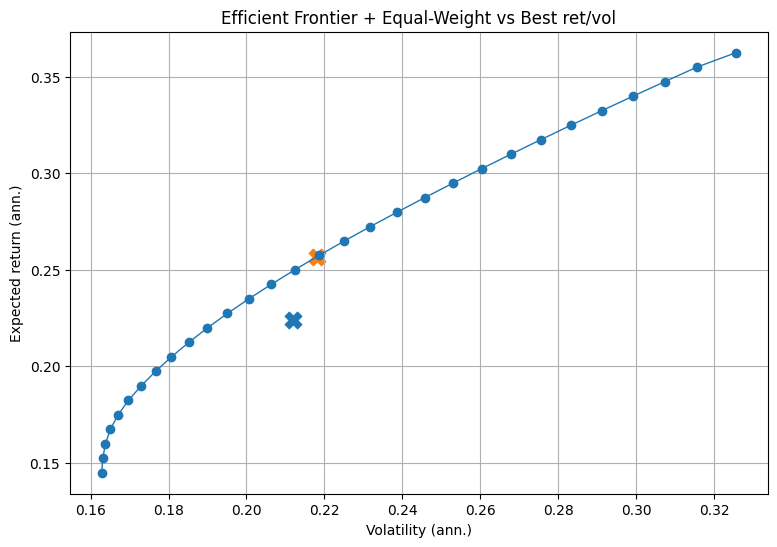

EqualW vol/ret: 0.21195805476885216 0.22382728016279854


In [56]:
w_eq = np.ones(len(mu))/len(mu)
eq_vol, eq_ret = port_vol(w_eq, cov), port_ret(w_eq, mu)

plt.figure(figsize=(9,6))
plt.plot(ef_s1["vol"], ef_s1["ret"], marker="o", linewidth=1)
plt.scatter([eq_vol],[eq_ret], marker="X", s=140)
plt.scatter([best_vol],[best_ret], marker="X", s=140)
plt.xlabel("Volatility (ann.)"); plt.ylabel("Expected return (ann.)")
plt.title("Efficient Frontier + Equal-Weight vs Best ret/vol")
plt.grid(True)
plt.show()

print("EqualW vol/ret:", eq_vol, eq_ret)